<a id='top'></a>
# Using the GAINS Module

Much of this content is borrowed from the [GAINS](https://wesleybeckner.github.io/gains/) documentation.

GAINS or Genetic Algorithm for Identifying Novel Structures is the package wrapper for our method of producing new ionic liquids.

[The engine module](#engine) gives an overview of the basic setup of the GAINS algorithm. If you would like to skip directly to how GAINS was employed in this research study you can do so [here](#framework).

In [7]:
import warnings
warnings.filterwarnings('ignore')

<a id='engine'></a>
## The engine module
[back to top](#top)

GAINS operates using the simplified molecular-input line-entry system ([SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)). We use this to create the molecular structures ([Chromosome](https://wesleybeckner.github.io/gains/gains.html#gains.engine.Chromosome) objects) to be manipulated by the engine. 

Let's explore the simple case of creating butane from propanol:

In [1]:
import gains as genetic
import numpy as np

target = "CCCC" #butane smiles
parent_candidates = np.array(["CCCO"]) #propanol smiles, numpy array

In order to begin manipulating the parent_candidate we have to, at a minimum, define three additional functions to interact with the engine: a fitness function, and two display functions; one for displaying accepted mutations one for displaying the final result. 

The fitness function is the most important user-defined function to interact with the engine, so we'll start there. It allows us to plug any desired objective into the engine; whether it be a quantitative structure property relationship (QSPR), an acitivity/toxicity score, or, as in this case, a simple similarity mapping between a target and a starting structure:

In [2]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem as Chem

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

You can read more of RDKit's documentation on molecular fingerprint similarity [here](http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity). Briefly, the fingerprinting algorithm identifies and hashes topological paths in the molecule before folding them down to a set density of bits. We exploit this in the engine to give us a fitness score for a candidate we are attempting to mutate towards the target structure.

The engine doesn't need to know anything about the target since the fitness function is defined on the user end. To avoid passing the target to and from the engine (and taking up cpu time) we define a helper function:

In [3]:
def fnGetFitness(genes):
    return get_fitness(genes, target)

This brings us to the last two functions we need to define, the display functions. There is a lot of freedom here to choose what we would like to print to the screen. At a minimum, the engine expects to pass the candidate (Chromosome object) and the current mutation to the display function; and the candidate's genes (SMILES string), target (int, float, or array), count of the mutation attempts (int), and two additional variables we'll get into later (the similarity score and corresponding molecular relative to the molecular solution) to the result display function.

In the following I've chosen to print the mutation performed, the fitness score, and the SMILES of the candidate in the display function and the number of atoms and number of mutations in the result display function:

In [5]:
def display(candidate, mutation):
    print("{:>20}{:>15}{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))

    
def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))

We have just two more items to pass to the engine: the geneSet object and the optimal fitness we are searching for.

The geneSet object contains the atoms and fragments the engine is allowed to use in any mutation attempt. For now these are hard coded into the engine and may be viewed [here](https://wesleybeckner.github.io/gains/gains.html#gains.engine.GeneSet).

The optimal fitness in our case is 1 (perfect mapping between candidate and target). But to be thorough we set this by passing the fitness score between the target and itself:

In [7]:
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)

We're now ready to put this all together:

In [8]:
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates)

  starting structure         0.3333           CCCO
 add_custom_fragment         0.3529         CCCCCO
         remove_atom         0.4615          CCCCO
         remove_atom         1.0000           CCCC
    number of atoms:              4
  mutation attempts:             34


In this simple example it took 34 mutation attempt to get from "CCCO" (propanol) to "CCCC" (butane); only 3 of which were accepted because they resulted in a higher fitness score than the candidate being mutated.

In the next section we'll go over the different mutations available to the engine.

## The mutate function

the GAINS engine can perform the following mutations to a molecular candidate:

* remove_atom
* add_atom
* replace_atom
* add_custom_fragment
* remove_custom_fragment
* add_rdkit_fragment
* remove_rdkit_fragment

To understand these sub functions, it is illustrative to look at the [function](https://wesleybeckner.github.io/gains/_modules/gains/engine.html#generate_geneset) that generates the geneSet:

```
    atoms = [6, 7, 8, 9, 5, 15, 16, 17]
    fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
    rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
    customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
    fcgen = FragmentCatalog.FragCatGenerator()
    m = Chem.MolFromSmiles('CCCC')
    fcgen.AddFragsFromMol(m, customFrags)
    return GeneSet(atoms, rdkitFrags, customFrags)
```

`atoms` is set according to atomic number: carbon, nitrogen, oxygen, fluorine, boron, phosphorus, sulfur, and chlorine. 

`rdkitFrags` is best understood by showing the output from rdkit itself:

In [1]:
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
import os
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
rdkitFrags.GetNumFuncGroups()

39

The engine is utilizing 39 built-in fragments from RDKit. We can view these fragments individually:

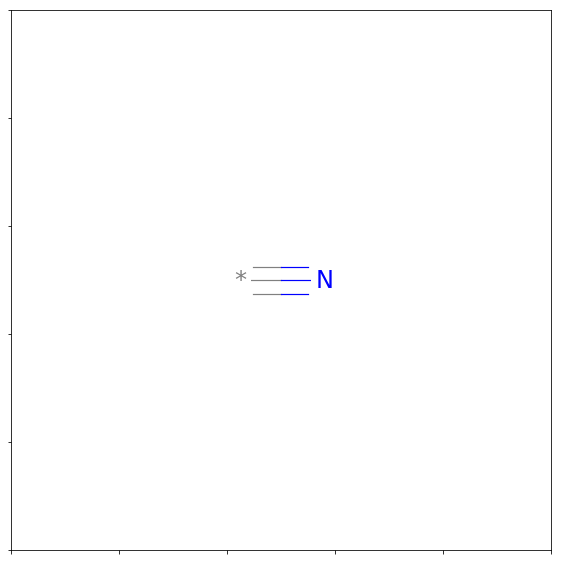

In [2]:
from rdkit.Chem import Draw
Draw.MolToMPL(rdkitFrags.GetFuncGroup(38))

and view all of their smiles strings:

In [4]:
from rdkit import Chem
for i in range(0,rdkitFrags.GetNumFuncGroups()):
    print(Chem.MolToSmiles(rdkitFrags.GetFuncGroup(i)))

[*]NC(C)=O
[*]C(=O)O
[*]C(=O)OC
[*]C(C)=O
[*]C(N)=O
[*]C(C)=O
[*]N=C=O
[*]N=C=S
[*]N(=O)O
[*]N=O
[*]=NO
[*]=NC
[*]N=C
[*]N=NC
[*]N=N
[*]N#N
[*]C#N
[*]S(N)(=O)=O
[*]NS(C)(=O)=O
[*]S(=O)(=O)O
[*]S(=O)(=O)OC
[*]S(C)(=O)=O
[*]S(=O)(=O)Cl
[*]S(C)=O
[*]SC
[*]S
[*]=S
[*]F
[*]C(C)(C)C
[*]C(F)(F)F
[*]C#C
[*]C1CC1
[*]OCC
[*]OC
[*]O
[*]=O
[*]N
[*]=N
[*]#N


You can learn more about RDKit fragments [here](http://www.rdkit.org/docs/GettingStartedInPython.html#molecular-fragments). The customFrags will change in future versions of GAINS. For now they are simply substructures of butane:

In [8]:
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
fcgen = FragmentCatalog.FragCatGenerator()
m = Chem.MolFromSmiles('CCCC')
fcgen.AddFragsFromMol(m, customFrags)
for i in range(3):
    print(customFrags.GetEntryDescription(i))

CC
CCC
CCCC


We've covered the important information you need to know to get up and running with GAINS. 

For convenience here is the full code of minimal functions we've described for interacting with the engine module:

In [9]:
import gains as genetic
import numpy as np
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem as Chem

target = "CCCC" #butane smiles
parent_candidates = np.array(["CCCO"]) #propanol smiles, numpy array

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

def fnGetFitness(genes):
    return get_fitness(genes, target)

def display(candidate, mutation):
    print("{:>20}{:>15}{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))

def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))
    
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates)

  starting structure         0.3333           CCCO
         remove_atom         0.6667            CCC
 add_custom_fragment         0.7500          CCCCC
         remove_atom         1.0000           CCCC
    number of atoms:              4
  mutation attempts:             41


<a id='framework'></a>

## The GA Framework for ILs
[back to top](#top)

An IL search in this study would be run like the following

In [3]:
from gains.salt_generator import generate_solvent
import salty
from random import randint

After importing the salty and gains libraries we define the models we'd like to load that were introduced in part 1 of this series in [qspr_nn_development](https://github.com/wesleybeckner/adaptive_learning_salts/blob/master/notebooks/qspr_nn_development.ipynb) as well as a target for each property

In [5]:
model_ID = ["cpt", "density"]
targets = [1000, 1000]

We can, at this point, begin to use GAINS in a simple search.

In the cell bellow we initialize a search for an IL with heat capacity of 1000 $J/mol/K$ and density of 1000 $kg/m^3$

In [8]:
generate_solvent(targets, model_ID)

C[N+]1(CCCC1)CCOC	0.7401449890136719	starting structure	[ 488.11 1007.82]	[1000, 1000]
COCC[N+]1(C)CCCC1C1CC1	0.7528000183105469	add_rdkit_fragment	[ 517.96 1012.36]	[1000, 1000]
CCCCC[N+]1(CCOC)CCCC1C1CC1	0.7727149963378906	add_custom_fragment	[549.01 996.42]	[1000, 1000]
CCCCC[N+]1(CCOC)CCCC1C1CC1CCC	0.7788349914550781	add_custom_fragment	[580.61 977.06]	[1000, 1000]
CCCCC[N+]1(CCOC)CCCC1C1C(CCC)C1C(C)=O	0.8362499999999999	add_rdkit_fragment	[681.1 991.4]	[1000, 1000]
CCCCC[N+]1(CCOC)CCCC1C1C(CC(C)N=C=O)C1C(C)=O	0.9170499877929688	add_rdkit_fragment	[ 877.12 1043.02]	[1000, 1000]
CCCCC[N+]1(CCOS)CCCC1C1C(CC(C)N=C=O)C1C(C)=O	0.9272050170898437	replace_atom	[1090.82 1054.77]	[1000, 1000]
C=C(C)C1C(CC(C)N=C=O)C1C1CCC[N+]1(CCCCC)CCOS	0.9313000183105469	replace_atom	[ 910.58 1047.98]	[1000, 1000]
C=C(C)C1C(CC(C)N=C=O)C1C1(CCC)CCC[N+]1(CCCCC)CCOS	0.9690349731445312	add_custom_fragment	[ 969.13 1031.06]	[1000, 1000]
Salt Smiles: 	C=C(C)C1C(CC(C)N=C=O)C1C1(CCC)CCC[N+]1(CCCCC)CCOS
Cation Heav

,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Prediction,MD Calculation,Error
0,C01_A01,C=C(C)C1C(CC(C)N=C=O)C1C1(CCC)CCC[N+]1(CCCCC)C...,29,0.515625,N-methylpyrrolidone,tetracyanoborate,"[969.13, 1031.06]",NaN,NaN


By default the GA looks for one successful hit, and returns a dataframe with useful information about the structure:

In [10]:
_8.columns

Index(['Salt ID', 'Salt Smiles', 'Cation Heavy Atoms',
       'Tanimoto Similarity Score', 'Molecular Relative', 'Anion',
       'Model Prediction', 'MD Calculation', 'Error'],
      dtype='object')

If we would like we can also quiet the engine during its search

In [11]:
generate_solvent?

Signature: generate_solvent(target, model_ID, heavy_atom_limit=50, sim_bounds=[0, 1.0], hits=1, write_file=False, seed=None, hull=None, simplex=None, path=None, exp_data=None, verbose=0, gen_token=False, hull_bounds=[0, 1], inner_search=True, parent_cap=25, mutation_cap=1000)
Docstring:
the primary public function of the salt_generator module

Parameters
----------
target : array, float, or int
    the desired property value to be achieved by the engine, if
    an array, a multi-output model must be supplied to the engine
model_ID : str
    the name of the model to be used by the engine. Gains has
    several built-in models to choose from
heavy_atom_limit : int, optional
    the upper value for allowable heavy atoms in the returned
    candidate
sim_bounds : array, optional
    the tanimoto similarity score between the returned candidate
    and its closest molecular relative in parent_candidates
hits : int, optional
    the number of desired solutions
write_file : boolean, optional
 

In [18]:
generate_solvent(targets, model_ID, verbose=3)

,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Prediction,MD Calculation,Error
0,C01_A01,CCCCCCCC(CC)CCNC([NH3+])C(CC)(CC)CS(N)(=O)=O.N...,25,0.546218,N-methylpyrrolidone,L-lysinate,"[1077.73, 999.06]",NaN,NaN


## Pareto Optimal Frontier Search

GAINS also allows more complicated search criteria out of the box, like the Pareto optimal frontier searches performed in the manuscript.

To initialize, GAINS needs the experimental data we'd like to create a convex hull from

In [21]:
T = [298.1, 298.16] 
P = [101, 102]
exp_data = ["cpt", "density"]
data = salty.aggregate_data(exp_data,T=T,P=P)
merged = salty.merge_duplicates(data)
to_hull = merged.iloc[:,2:4]

Identified 82 unique salts in 1622 datapoints


to_hull is a dataframe with 82 data points for density and heat capacity. GAINS will use this information to automatically compute a CH:

In [23]:
to_hull.head()

,"Specific density, kg/m<SUP>3</SUP>_mean","Heat capacity at constant pressure, J/K/mol_mean"
0,1237.45,820.20
1,1187.70,905.00
2,1278.35,754.65
3,1061.70,522.00
4,1094.50,450.00


Finally, we need to asign an edge and distance for the GAINS to select proper targets. a hull bound of [-.1,.1] will search for targets within/out 10% of the assigned simplex. assigning a simplex id of `any` will cause GAINS to randomly re-assign to any simplex. setting initial targets of [0,0] will cause GAINS to exhaust its initial genetic line (as no IL should have those properties) and start the target reassignment process.

In [29]:
simplex_id = 'any'
hull_bounds=[0,1]
targets=[0,0]

In [ ]:
generate_solvent(targets, model_ID, hull=to_hull, simplex=simplex_id,
                 verbose=3, hull_bounds=hull_bounds)